### IMPORT SECTION

In [388]:
#Gül Eda Aydemir
#504201574
#########################
import numpy as np # pip3 install matplotlib
import matplotlib.pyplot as plt # pip3 install matplotlib

import networkx as nx

from networkx import gnm_random_graph, adjacency_matrix
import networkx.algorithms.community as nx_comm
from networkx.algorithms.smallworld import random_reference

import random
import community # can be installed with: "pip install python-louvain"
from numpy import linalg as LA
from tqdm import tqdm
import pandas as pd
from scipy import stats
from scipy.interpolate import interp1d
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import math
import scipy.io as sio
from skimage import data, segmentation, color
from skimage.future import graph

#For Part 3.3
from PIL import Image
from pylab import *
from numpy import *
from scipy.cluster.vq import *

### LOADING EXERCISE DATA

In [389]:
#Part 1: Bellman-Ford shortest path algorithm
temp_data = sio.loadmat('Exercise_1_data/adjacencyMatrix.mat') 
A1 = np.array(list(temp_data.values()),dtype=object)[3]

#Global efficiency, diffusion efficiency and graph morphospace
temp_data = sio.loadmat('Exercise_2_data/brainGraph1.mat') 
A_B1 = np.array(list(temp_data.values()),dtype=object)[3]
temp_data = sio.loadmat('Exercise_2_data/brainGraph2.mat')
A_B2 = np.array(list(temp_data.values()),dtype=object)[3]

#Part3: Graph self-diffusion for image segmentation
im1 = Image.open('Exercise_3_data/image1.jpg') 
im1 = im1.resize((int(list(im1.size)[0]/8),int(list(im1.size)[1]/8)),Image.NEAREST) #image is resized in order to deal with the memory limit

im2 = Image.open('Exercise_3_data/image2.jpg')
im2 = im2.resize((int(list(im2.size)[0]/8),int(list(im2.size)[1]/8)),Image.NEAREST)

# 🏁 START POINT OF THE HOMEWORK

## 1️⃣- Bellman-Ford shortest path algorithm [20%]
The Bellman-Ford algorithm is a generalization of Dijkstra’s algorithm to directed graphs with no negative cycles. Given a weighted matrix A of a directed graph G, an element A(i, j) denotes the weight of the edge from node i to node j.

### 🔺 (1.1) Explain the key steps of Bellman-Ford algorithm (one-by-one). [5%]

* Initial node is assigned a path length of zero, while all other nodes are assigned to infinity.
* Start by visiting the neighbors of the initial node. The algorithm stops when all nodes are visited.

    > 0) Initialize path length in each node. <br>
    > 1) From starting node, visit(\**) the node with the smallest known distance/cost.<br>
    > 2) Once we've moved to the smallest-cost node, check each of its neighboring nodes.<br>
    > 3) Calculate the distance/cost for the neighboring nodes by summing the cost of the edges leading from the start node.<br>
    > 4) If the distance/cost to a node we are checking is less than a known distance, update the shortest distance for that vertex.<br>

 ** 1- create a list to keep track of each visited nodes. 2- create a list to keep track of unvisited nodes.
 

### 🔺 (1.2) Write a function called BellmanFordAlgo that takes (i) A and (2) a starting node ID as inputs, and outputs an array as in Graph Theory Blink 5.4a, where each row represents a node in the graph G and comprising three columns (nodes, shortest distance from source input node, previous node). [10%]

In [429]:
def BellmanFordAlgo(A, starting_node_ID): 
    #Inputs/ A:Adjacency Matrix,type: numpy.ndarray (A) and the ID of the starting node 
    
    #For Output
    index=[i for i in range (1,len(A)+1)]
    columns=['Nodes|', 'Shortest distance from source node|','Previous node|']
    Output=pd.DataFrame(columns=columns, index=index)
    
    #Initial node is assigned a path length of zero, while all other nodes are assigned to infinity.  
    D=[math.inf]*len(A)
    D[starting_node_ID-1]=0 #Python starts indexing from 0,here we use starting_node_ID-1.
    
    #step1: each edge is relaxed one by one, repeating |V|-1 times.
    for k in range (0, len(A)-1):
        for i in range(0, len(A)):
            for j in range(0, len(A)):
                if A[i][j] != 0:
                    if (D[i] != float("Inf") and D[i] + A[i][j]< D[j]):
                        D[j] = D[i]+ A[i][j]
                        #Output arrangements.
                        Output.iloc[starting_node_ID-1][1]=D[starting_node_ID-1]
                        Output.iloc[starting_node_ID-1][2]=starting_node_ID
                        Output.iloc[j][0]=j+1 #indexing
                        Output.iloc[j][1]= D[j]
                        Output.iloc[j][2]=i+1 #indexing
                        
    #step2: the negative weight cycles are detected. 
    for i in range(0, len(A)):
        for j in range(0, len(A)):
            if A[i][j] !=0:
                if (D[i] !=  float("Inf") and D[i] + A[i][j]< D[j]):
                    print("Error: Graph contains negative weight cycle")
                    
    for i in range (1,len(A)+1):
        Output['Node'] = i
    
    #To have an array output needs to activate code below:
    #Output = Output.values  #Display output array.
    
    return Output

### 🔺 (1.3) Run your function in the Jupyter Notebook on the input adjacency matrix A (see Fig. fig:1) and display the output array. You can find the data inside ‘Exercise 1 data’ folder. [5%]

In [391]:
for i in range(1, len(A1)+1):
    print('\n','Shortest path from node (source node)', i, '\n', BellmanFordAlgo(A1,i), '\n')


 Shortest path from node (source node) 1 
   Nodes| Shortest distance from source node| Previous node|  Node
1    NaN                                   0              1     6
2      2                                   1              1     6
3      3                                   2              1     6
4      4                                   5              2     6
5      5                                   8              4     6
6      6                                   5              3     6 


 Shortest path from node (source node) 2 
   Nodes| Shortest distance from source node| Previous node|  Node
1    NaN                                 NaN            NaN     6
2    NaN                                   0              2     6
3    NaN                                 NaN            NaN     6
4      4                                   4              2     6
5      5                                   7              4     6
6      6                                   5        

## 2️⃣- Global efficiency, diffusion efficiency and graph morphospace [40%]

> 1) Global Efficiency : is the reciprocal of the harmonic mean of its path lengths. <br>
> 2) Diffusion Efficiency: is the number of times a random walker needs to commance a new random walk from his starting point to ensure he reaches his destination on at least one occasion by the shortest path.<br>
> 3) Graph Morphospace: 'reveals the extent to which the space is filled by existing networks, thus allowing a distinction between actual and impossible designs and highlighting the generative potential of rules and constraints that pervade the evolution of complex systems.('https://pubmed.ncbi.nlm.nih.gov/25540237/)<br> 

### 🔺 (2.1) Write a function globalEfficiency, which inputs a graph adjacency matrix A and outputs the global efficiency value. [5%]

In [392]:
def globalEfficiency (A):
    #Input/ A:Adjacency Matrix, type: numpy.ndarray
    #Output/ Global Efficiency value of A.
    
    #Returns a graph from a 2D NumPy array.
    G = nx.from_numpy_array(A) 
    
    # Graph Theory Blink 5.5/ 1/N(N-1)
    norm = 1 / (len(G.nodes) * (len(G.nodes) -1 )) 
    lij = dict(nx.all_pairs_dijkstra_path_length(G, weight="weight"))
    gEff = 0
    
    #Graph Theory Blink 5.5/ sum of 1/lij  
    for i in G.nodes:
        for j in range (0, len(lij[i])):
            if np.array(list(lij[i].values()))[j] != 0:
                gEff += (1/np.array(list(lij[i].values()))[j])
                
    #Graph Theory Blink 5.5/ 1/N(N-1) * sum(1/lij)
    return norm*gEff 

In [393]:
print("brainGraph1's Global Efficiency value is",globalEfficiency(A_B1))
print("brainGraph2's Global Efficiency value is",globalEfficiency(A_B2))

brainGraph1's Global Efficiency value is 59.09230732440917
brainGraph2's Global Efficiency value is 67.1795026800395


### 🔺 (2.2) Write a function diffusionEfficiency, which inputs a graph adjacency matrix A and outputs the diffusion efficiency value. [5%]

In [394]:
def diffusionEfficiency (A):
    #Input/ A:Adjacency Matrix, type: numpy.ndarray
    #Output/ Diffusion Efficiency value of A.
    
    #Graph Theory Blink (6.6)/ 1/N(N-1)
    norm = 1 / (len(A) * (len(A)-1))
    
    #Graph Theory Blink (6.5)/ U = W.(S^-1) // Markov Chain - Graph Laplacian, where W is Adjacency Matrix A
    def Uij(A):
        
        #Strengths of the ith node, array
        S = [] 
        for i in range (0, len(A)):
            s = 0
            for j in range (0, len(A)):
                s += A [i][j]
            S.append(s)
                     
        #Compute the (multiplicative) inverse of a matrix.
        S_1 = np.linalg.inv(np.diag(S))
                     
        #Compute the dot product of two or more arrays in a single function call, while automatically selecting the fastest evaluation order.
        U = np.linalg.multi_dot([A, S_1])
        return U

    #Graph Theory Blink (6.6)/ sum(1/<xij>)
    D = 0
    for j in range(0, len(A)):
        U = Uij(A)
        U[j] = [0 for i in U[j]]
        U = 1 / (1-U) # RuntimeWarning :(
        for i in range (0, len(A)):
            if i != j:
                x = 0
                for n in range (0, len(A)):
                    x += U[n][i]
                if x != 0:
                    D += 1/x
                    
    #Graph Theory Blink 6.6/ 1/N(N-1) * sum(1/xij)
    return norm * D

In [395]:
print("brainGraph1's Diffusion Efficiency value is",diffusionEfficiency(A_B1))
print("brainGraph2's Diffusion Efficiency value is",diffusionEfficiency(A_B2))

brainGraph1's Diffusion Efficiency value is 0.008545271352377743
brainGraph2's Diffusion Efficiency value is 0.008545214049446874


### 🔺 (2.3) Create a scatter plot where x-axis represents threshold value α ∈ [0 : 0.1 : 0.9] (0.1 denotes the threshold step size) and the y-axis represents the global efficiency Eglob of brain graph adjacency matrices ‘Exercise 2 data/ brainGraph1.mat’ and ‘Exercise 2 data/ brainGraph2.mat’ (Fig. fig:2). By thresholding each adjacency matrix at different threshold values α ∈ [0 : 0.1 : 0.9], examine how its global and diffusion efficiencies change. Use two different colors to compare the change in global efficiency across both brain graphs. [5%]

In [396]:
def threshold(A, n):
    #Input/ Adjacency matrix (A), threshold value (n)
    #Output/ thresholded graph
    
    #Return a new array of given shape and type, filled with zeros.
    aThreshold = np.zeros([len(A), len(A)])
    
    #if given A[i][j] is smaller than given n value, new value will be 0, else same.
    for i in range(0, len(A)):
        for j in range(0, len(A)):
            if A[i][j] < n:
                aThreshold[i][j] = 0
            else:
                aThreshold[i][j] = A[i][j]
    return aThreshold  

#### ▪️Plotting Figure 1 : Global efficiency values for thresholded graphs

In [397]:
columns = ["Global_Efficiency", "Threshold"]
index = [i for i in np.arange(0, 1, 0.1)]
GE_B1 = pd.DataFrame(columns=columns, index=index)
for i in range (0,10):
#for i in range (1,10): #plots global efficiency values by discarding the global efficiency values for the unthresholded graphs
    GE_B1.iloc[i,0] = globalEfficiency(threshold(A_B1,GE_B1.index[i]))
    GE_B1.iloc[i,1] = GE_B1.index[i]
    
    #print(GE_B1)
    
GE_B2 = pd.DataFrame(columns=columns, index=index)
for i in range (0,10):
#for i in range (1,10): #plots global efficiency values by discarding the global efficiency values for the unthresholded graphs
    GE_B2.iloc[i,0] = globalEfficiency(threshold(A_B2,GE_B2.index[i]))
    GE_B2.iloc[i,1] = GE_B2.index[i]
    
     #print(GE_B2)

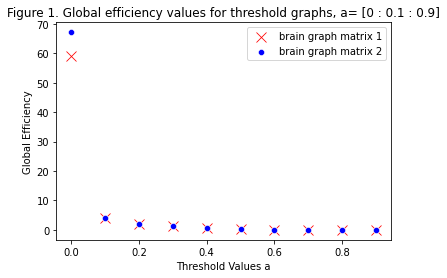

In [398]:
ax=sns.scatterplot(data=GE_B1, x="Threshold", y="Global_Efficiency", color="red", marker='x', s=100, label= 'brain graph matrix 1')
ax=sns.scatterplot(data=GE_B2, x="Threshold", y="Global_Efficiency", color="blue", label= 'brain graph matrix 2')
ax.legend()
plt.ylabel('Global Efficiency')
plt.xlabel('Threshold Values a')
plt.title('Figure 1. Global efficiency values for threshold graphs, a= [0 : 0.1 : 0.9]')
plt.show()

The global efficiency value of brain graph matrices without any threshold can be seen outlier to the thresholded brain graphs. 

Changing "for i in range (0,10):" to "for i in range (1,10):" plots global efficiency values by discarding the global efficiency values for the unthresholded graphs. Therefore, the difference between tresholded brain graphs vs. unthresholded brain graphs will be displayed more clearly.

By the threshold value 0.6, it can be seen that the graph continues steadily and closes to the 0. Thats mean,the shorter edges are removed one by one results to have longer shortest distance between nodes and after a certain value, there is no path between nodes.

### 🔺 (2.4) In a second figure, plot the diffusion efficiency Ediff of both matrices against α. [5%]

#### ▪️Plotting Figure 2 : Diffusion efficiency values for thresholded graphs

In [399]:
columns = ["Diffusion_Efficiency", "Threshold"]
index = [i for i in np.arange(0, 1, 0.1)]
DE_B1 = pd.DataFrame(columns=columns, index=index)
for i in range (0,10):
#for i in range (1,10): #plots diffusion efficiency values by discarding the diffusion efficiency values for the unthresholded graphs
    DE_B1.iloc[i,0] = diffusionEfficiency(threshold(A_B1,DE_B1.index[i]))
    DE_B1.iloc[i,1] = DE_B1.index[i]
    
DE_B2=pd.DataFrame(columns=columns, index=index)
for i in range (0,10):
#for i in range (1,10): #plots diffusion efficiency values by discarding the diffusion efficiency values for the unthresholded graphs
    DE_B2.iloc[i,0] = diffusionEfficiency(threshold(A_B2,DE_B2.index[i]))
    DE_B2.iloc[i,1] = DE_B2.index[i]

/var/folders/vr/x5v7zsw95h50jgx7yhmv13x80000gp/T/ipykernel_23049/2491023638.py:31: RuntimeWarning: divide by zero encountered in true_divide
  U = 1 / (1-U) # RuntimeWarning :(


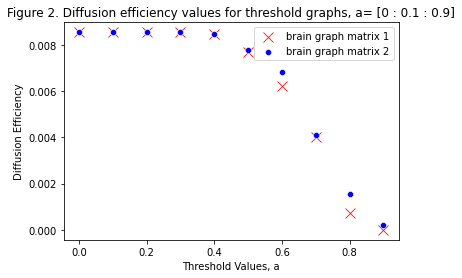

In [400]:
ax=sns.scatterplot(data=DE_B1, x="Threshold", y="Diffusion_Efficiency", color="red", marker='x', s=100, label= 'brain graph matrix 1')
ax=sns.scatterplot(data=DE_B2, x="Threshold", y="Diffusion_Efficiency", color="blue", label= 'brain graph matrix 2')
ax.legend()
plt.ylabel('Diffusion Efficiency')
plt.xlabel('Threshold Values, a')
plt.title('Figure 2. Diffusion efficiency values for threshold graphs, a= [0 : 0.1 : 0.9]')
plt.show()

### 🔺 (2.5) What conclusions can you derive from previous plots? Compare diffusion and global efficiencies within a single graph and across both graphs. [5%]

#### ▪️Plotting Figure 3 : Efficiency values for thresholded graphs

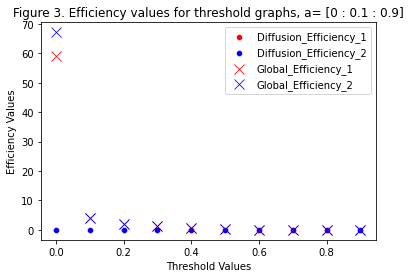

In [401]:
GE_B1["Diffusion_Efficiency"]= DE_B1["Diffusion_Efficiency"]
GE_B2["Diffusion_Efficiency"]= DE_B2["Diffusion_Efficiency"]

ax=sns.scatterplot(data=GE_B1, x="Threshold", y="Diffusion_Efficiency", color="red", label= 'Diffusion_Efficiency_1')
ax=sns.scatterplot(data=GE_B2, x="Threshold", y="Diffusion_Efficiency", color="blue", label= 'Diffusion_Efficiency_2')
ax=sns.scatterplot(data=GE_B1, x="Threshold", y="Global_Efficiency", color="red", marker='x', s=100 , label= 'Global_Efficiency_1')
ax=sns.scatterplot(data=GE_B2, x="Threshold", y="Global_Efficiency", color="blue", marker='x', s=100, label= 'Global_Efficiency_2')
ax.legend()

plt.ylabel('Efficiency Values')
plt.xlabel('Threshold Values')
plt.title('Figure 3. Efficiency values for threshold graphs, a= [0 : 0.1 : 0.9]')
plt.show()

From plots given through Figure 1, 2 and 3, one can provide following comments:

Thresholding given graphs, global efficiency values has decreased since the shorter edges are removed one by one results to have longer shortest distance between nodes.

It is seen from both global efficiency and diffusion efficiency results, after threshold value 0.5 (approximately), the communication within the graphs has damaged significantly.

Thresholding the graphs hasn't affect too much the diffusion efficiency before a certain value, 0.4.

Since global efficiency values have decreased significantly after thresholding for 0.1, it can be concluded that majority of the edges have 0.1 weights in both brain graph 1 and brain graph 2.

**Note: Change 'for i in range (1,10)' for to see plots only for the thresholded efficiency values.

### 🔺 (2.6) Plot a morphospace [1] for the set of thresholded brain graphs at α ∈ [0 : 0.1 : 0.9], where the x-axis denotes Ediff and y-axis denotes Eglob. Use two different colors to compare the two thresholded graph sets derived from each brain graph, respectively. [10%]

#### ▪️Plotting Figure 4 : Morphospace for thresholded graphs

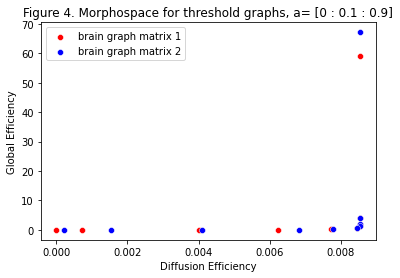

In [402]:
ax=sns.scatterplot(data=GE_B1, x="Diffusion_Efficiency", y="Global_Efficiency", color="red", label= 'brain graph matrix 1')
ax=sns.scatterplot(data=GE_B2, x="Diffusion_Efficiency", y="Global_Efficiency", color="blue", label= 'brain graph matrix 2')
plt.ylabel('Global Efficiency')
plt.xlabel('Diffusion Efficiency')
plt.title('Figure 4. Morphospace for threshold graphs, a= [0 : 0.1 : 0.9]')
plt.show()

### 🔺 (2.7) Discuss the information flow efficiency for both brain graphs based on your morphospace plot. [5%]

From the results visualised with a morphospace in Figure 4, it is seen that until a certain threshold value which is known as 0.5 from previous plots, global efficiency and diffusion efficiency decreased.

For this section, one can say that several linked cluster topology of the graphs are dissolved while still preserving a/some core/cores with perpheral nodes that can be seen as rich-club networks or core-periphery organization.

After threshold value 0.4 and 0.6 for diffusion efficency and global efficiency respectively, the efficiencies decreased as the threshold value increased. For that section, it can be concluded that from **clique** structure, graphs have started to have **chain or ring** like topology.

The information flow efficiency is decreased by increasing threshold value. Between the threshold values 0.1-0.5, core nodes have showed up, where the information is distributed to the nodes from those core structure, which makes the graphs more vulnerable to targeted attacks. After the threshold value 0.6, where graphs have long chain structure, the information flow efficiency gets minimized.

#### Plotting the thresholded and unthresholded brain graphs for visualization. 

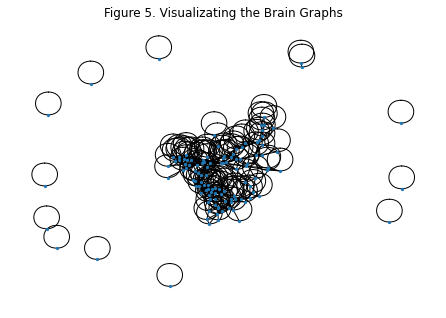

In [403]:
rows, cols = np.where(threshold(A_B1,0.5)) #Play with the values A: A_B1 or A_B2, n:[0,1].
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw(gr, node_size=5)
plt.title('Figure 5. Visualizating the Brain Graphs')
plt.show()

## 3️⃣- Graph self-diffusion for image segmentation [2] [40%]

This part is related to lecture 7: https://www.youtube.com/watch?v=h-ru40T6SGU&list=PLug43ldmRSo3MV-Jgjr30E5SpwNKkjTvJ&index=29 and the research paper on ‘Affinity learning via self-diffusion for image segmentation and clustering’
by Wang et al. --> https://pages.ucsd.edu/~ztu/publication/cvpr12_sd.pdf

### 🔺 (3.1) Write a function called selfDiffuse that takes (i) a weighted graph adjacency matrix (i.e., similarity matrix) W and outputs the diffused matrix W⋆ (check algorithm fig:3.). Make sure that your algorithm automatically sets the optimal number of diffusion iterations t⋆ as explained in the paper [2]. [10%]

In [404]:
#function to find optimal t value
def t_optimal(W,P):
    #the eigenvalues of P matrix in descending order
    vals,vecs = np.linalg.eig(P)
    sort = np.argsort(vals)[::-1]
    vals = vals[sort]
    #first ln 
    wp = np.dot(W,P)
    denom1 = len(vals)-P.trace()
    denom2 = np.linalg.norm(W-wp-np.identity(len(W)))
    denom = denom1 * denom2
    ln1 = math.log(0.001 / denom) # 0.0001 is selected as small number
    #second ln 
    ln2 = math.log(vals[1]-0.05) # C is set to 0.05 as authors indicate that 0.05 found as the best value for C
    t = np.ceil(ln1/ln2)
    #if one wants to check the t_opt, need to run the code below:
    #print(t)
    return int(t)

In [405]:
def selfDiffuse(W):
    #Input/ weighted graph adjacency matrix (W)
    #Output/ diffused matrix W⋆
    
    #Graph Theory Blinks 7.1/ D is a diagonal matrix, D(i,i) = sum(W(i,k)) from k=1 to n.
    D=[]
    for i in range (0, len(W)):
        w = 0
        for j in range (0, len(W)):
            w += W[i][j]
        D.append(w)
        
    #Graph Theory Blinks 7.1/ Compute the (multiplicative) inverse of a matrix.
    D_1 = np.linalg.inv(np.diag(D)) 
    
    #Graph Theory Blinks 7.1/ Dot product of two arrays. P = (D^-1)*W
    P = np.dot(D_1,W)
    
    #Graph Theory Blinks 7.1/ Wt = (Wt-1)*P + I 
    for i in range (0,t_optimal(W,P)):
        W = np.dot(W,P) + np.identity(len(W))
        
    #Graph Theory Blinks 7.1/ W* = Wt * (D^-1)    
    return np.dot(W,D_1)

In [406]:
SF_B1 = selfDiffuse(A_B1)
SF_B2 = selfDiffuse(A_B2)

### 🔺 (3.2) Run selfDiffuse on both brain graph adjacency matrices ‘Exercise 2 data/ brainGraph1.mat’ and ‘Exercise 2 data/ brainGraph2.mat’. For each brain graph, visualize both original and diffused matrices. [10%]

#### ▪️Plotting Adjacency Matrix for Brain Graph 1

<AxesSubplot:>

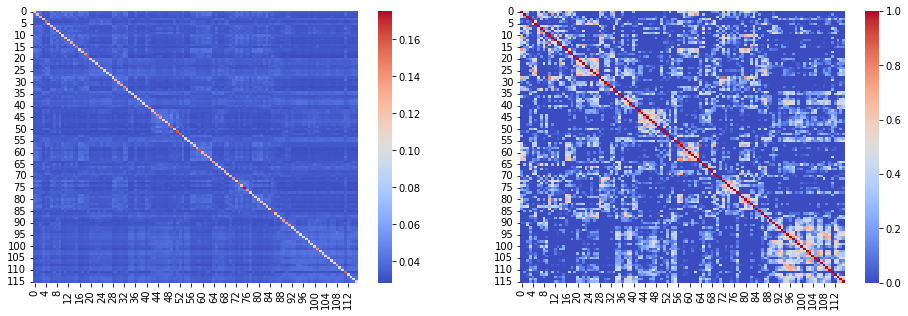

In [407]:
#Exercise_2_data/brainGraph1.mat plots
fig= plt.figure(figsize=(16,5))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
sns.heatmap(pd.DataFrame(SF_B1),cmap="coolwarm", ax=ax1)
sns.heatmap(pd.DataFrame(A_B1),cmap="coolwarm", ax=ax2)

#### ▪️Plotting Adjacency Matrix for Brain Graph 2

<AxesSubplot:>

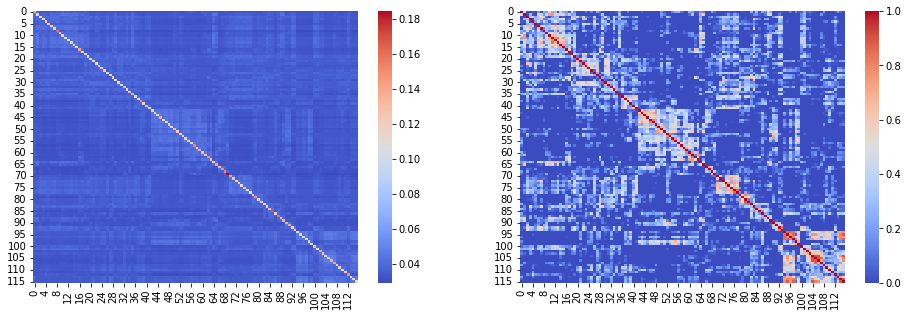

In [408]:
#Exercise_2_data/brainGraph2.mat plots
fig= plt.figure(figsize=(16,5))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
sns.heatmap(pd.DataFrame(SF_B2),cmap="coolwarm", ax=ax1)
sns.heatmap(pd.DataFrame(A_B2),cmap="coolwarm", ax=ax2)

### 🔺 (3.3) Given the 2 images taken from the Berkeley Segmentation Data Set, generate the segmentation maps of each image using the Normalized Cut Python code https://github.com/marktao99/python/blob/master/CVP/samples/ncut.py. Display each original image and its corresponding output segmentation map. [10%]

In [409]:
def cluster(S,k,ndim):
    """ Spectral clustering from a similarity matrix."""
    
    # check for symmetry
    #if sum(abs(S-S.T)) > 1e-10:
    #   print('not symmetric')
    
    # create Laplacian matrix
    rowsum = sum(abs(S),axis=0)
    D = diag(1 / sqrt(rowsum + 1e-6))
    L = dot(D,dot(S,D))
    
    # compute eigenvectors of L
    U,sigma,V = linalg.svd(L,full_matrices=False)
    
    # create feature vector from ndim first eigenvectors
    # by stacking eigenvectors as columns
    features = array(V[:ndim]).T

    # k-means
    features = whiten(features)
    centroids,distortion = kmeans(features,k)
    code,distance = vq(features,centroids)
        
    return code,V

def ncut_graph_matrix(im,sigma_d=1e2,sigma_g=1e-2):
    """ Create matrix for normalized cut. The parameters are 
        the weights for pixel distance and pixel similarity. """
        
    m,n = im.shape[:2] 
    N = m*n
    
    # normalize and create feature vector of RGB or grayscale
    if len(im.shape)==3:
        for i in range(3):
            im[:,:,i] = im[:,:,i] / im[:,:,i].max()
        vim = im.reshape((-1,3))
    else:
        im = im / im.max()
        vim = im.flatten()
    
    # x,y coordinates for distance computation
    xx,yy = meshgrid(range(n),range(m))
    x,y = xx.flatten(),yy.flatten()
    
    # create matrix with edge weights
    W = zeros((N,N),'f')
    for i in range(N):
        for j in range(i,N):
            d = (x[i]-x[j])**2 + (y[i]-y[j])**2 
            W[i,j] = W[j,i] = exp(-1.0*sum((vim[i]-vim[j])**2)/sigma_g) * exp(-d/sigma_d)
    
    return W

For more information, http://programmingcomputervision.com/downloads/ProgrammingComputerVision_CCdraft.pdf pages(248,252)

#### ▪️Plotting Normalized Cut for Image 1

In [410]:
#affinity matrix obtained by N-cut algorithm
#create normalized cut matrix
W_Ncut1 = ncut_graph_matrix(np.asarray(im1).astype(np.float32))

In [411]:
m1,n1 = np.array(im1).shape[:2]
segs_1 = []
for i in range(0,3):
    l_1, V =cluster(W_Ncut1,i+2,i+1)
    segs_1.append(color.label2rgb(np.array(l_1).reshape(m1,n1), np.array(im1), kind='avg', bg_label=0))

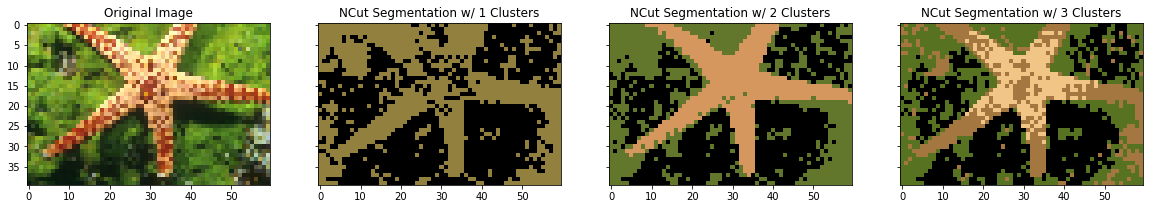

In [412]:
fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(20, 10))
ax[0].set_title('Original Image')
ax[0].imshow(im1)

for i in range(0,3):
    ax[i+1].set_title('NCut Segmentation w/ %i Clusters' %(i+1))
    ax[i+1].imshow(segs_1[i].astype('uint8'))

plt.show()

                Figure 6. Visualizating the Star Fish Image Without Self-Diffusing



#### ▪️Plotting Normalized Cut for Image 2

In [413]:
#affinity matrix obtained by N-cut algorithm
#create normalized cut matrix
W_Ncut2=ncut_graph_matrix(np.asarray(im2).astype(np.float32))

In [414]:
k=[5,7,12]
ndim=[4,6,11]
m2,n2 = np.array(im2).shape[:2]
segs_2 = []
for i in range(0,3):
    l_2, V =cluster(W_Ncut2,k[i],ndim[i])
    segs_2.append(color.label2rgb(np.array(l_2).reshape(m2,n2), np.array(im2), kind='avg', bg_label=0))

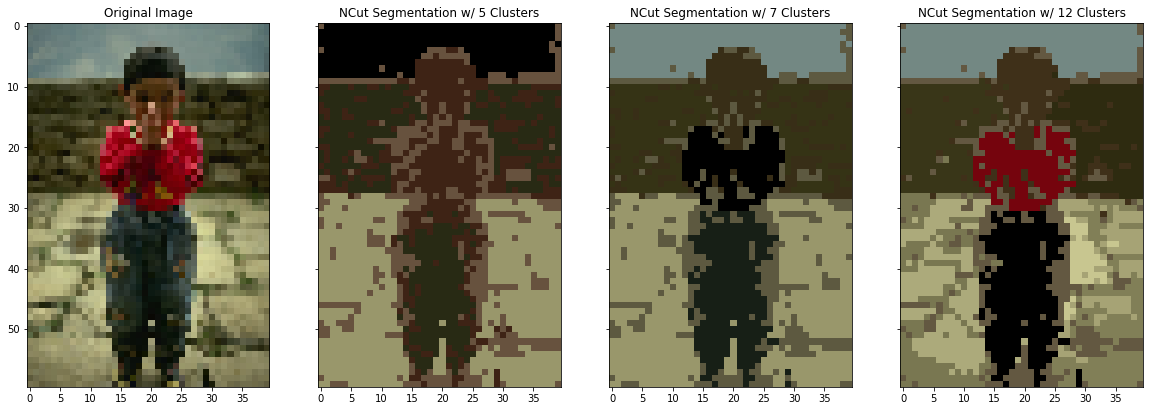

In [415]:
fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(20, 200))
ax[0].set_title('Original Image')
ax[0].imshow(im2)

for i in range(0,3):
    ax[i+1].set_title('NCut Segmentation w/ %i Clusters' %(k[i]))
    ax[i+1].imshow(segs_2[i].astype('uint8'))
plt.show()

                  Figure 7. Visualizating the Child Image Without Self-Diffusing

### 🔺 (3.4) For each image, change the Normalized Cut Python by applying selfDiffuse to the similarity matrix W, then use W⋆ to perform the normalized cut and output the image segmentation map. For each image, display 5 different normalized cut segmentation maps when varying the diffusion threshold from t=1 to t=2×t⋆ (similartoFig1in[2]andFigfig:4below).[10%]

In [416]:
def selfDiffuse_t(W,t):
    #given similarity matrix W, self diffusion is made t times
    D=[]
    for i in range (0, len(W)):
        w=0
        for j in range (0, len(W)):
            w+=W[i][j]
        D.append(w)
    D_1=np.linalg.inv(np.diag(D)) 
    P=np.dot(D_1,W)
    for i in range (0,t):
        W=np.dot(W,P)+np.identity(len(W))
    return np.dot(W,D_1)  

In [417]:
def ncut_graph_matrix_SF(im,t,sigma_d=1e2,sigma_g=1e-2): # t is added as input
    m,n = im.shape[:2] 
    N = m*n
    
    # normalize and create feature vector of RGB or grayscale
    if len(im.shape)==3:
        for i in range(3):
            im[:,:,i] = im[:,:,i] / im[:,:,i].max()
        vim = im.reshape((-1,3))
    else:
        im = im / im.max()
        vim = im.flatten()
    
    # x,y coordinates for distance computation
    xx,yy = meshgrid(range(n),range(m))
    x,y = xx.flatten(),yy.flatten()
    
    # create matrix with edge weights
    W = zeros((N,N),'f')
    for i in range(N):
        for j in range(i,N):
            d = (x[i]-x[j])**2 + (y[i]-y[j])**2 
            W[i,j] = W[j,i] = exp(-1.0*sum((vim[i]-vim[j])**2)/sigma_g) * exp(-d/sigma_d)
    
    W_SF = selfDiffuse_t(W,t) # W matrix is self diffused t time
    return  W_SF

In [418]:
def t_opt(W):
    #given W similarity matrix, optimum number of iteration is printed
    D = []
    for i in range (0, len(W)):
        w = 0
        for j in range (0, len(W)):
            w += W[i][j]
        D.append(w)
    D_1 = np.linalg.inv(np.diag(D)) 
    P = np.dot(D_1,W)
    #same with t_optimal(w,P) function
    vals,vecs = np.linalg.eig(P)
    sort = np.argsort(vals)[::-1]
    vals = vals[sort]
    wp = np.dot(W,P)
    denom1 = len(vals)-P.trace()
    denom2 = np.linalg.norm(W-wp-np.identity(len(W)))
    denom = denom1*denom2
    ln1 = math.log(0.0001/denom)
    ln2 = math.log(vals[1]-0.05) 
    t = np.ceil(ln1/ln2)
    return int(t)

#### ▪️Displaying 5 different normalized cut segmentation maps on Image 1

In [419]:
#5 different iterations
t1=1
t3=t_opt(W_Ncut1)
t5=2*t3
t2=int(t1+(t3-t1)/2)
t4=int(t3+(t5-t3)/2)

m1,n1 = np.array(im1).shape[:2]
t=[t1, t2, t3, t4, t5]

In [420]:
t

[1, 200, 399, 598, 798]

In [421]:
print("This part takes some time.. (about 8-9 minutes) ")
labels = []
for i in tqdm(range(0,5)):
    l1, V =cluster(ncut_graph_matrix_SF(np.asarray(im1).astype(np.float32),t[i]),2,1)
    labels.append(np.array(l1).reshape(m1,n1))

This part takes some time.. (about 8-9 minutes) 


100%|████████████████████████████████████████████| 5/5 [08:40<00:00, 104.17s/it]


In [422]:
segmentations = []
for i in range(0,5):
    segmentations.append(color.label2rgb(labels[i], np.array(im1), kind='avg', bg_label=0))

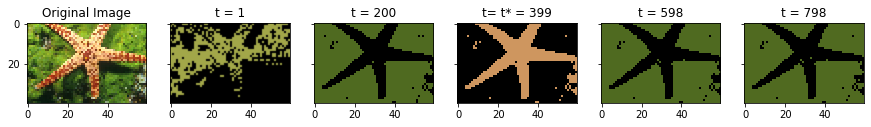

In [423]:
fig, ax = plt.subplots(ncols=6, sharex=True, sharey=True, figsize=(15, 10))
ax[0].set_title('Original Image')
ax[0].imshow(im1)

for i in range(0,5):
    if i == 2:
        ax[i+1].set_title('t= t* = %i' %t[i])
    else:
        ax[i+1].set_title('t = %i' %t[i])
    ax[i+1].imshow(segmentations[i].astype('uint8'))

plt.show()

                Figure 8. Visualizating the Star Fish Image With Self-Diffusing



Self diffusion can improve image segmentation.(Figure 6 and 8)

#### ▪️Displaying 5 different normalized cut segmentation maps on Image 2

In [424]:
t1=1
t3=t_opt(W_Ncut2)
t5=2*t3
t2=int(t1+(t3-t1)/2)
t4=int(t3+(t5-t3)/2)

m2,n2 = np.array(im2).shape[:2]
t_2=[t1, t2, t3, t4, t5]

In [425]:
t_2

[1, 207, 413, 619, 826]

In [426]:
print("This part takes some time.. (about 8-9 minutes) ")
labels_2 = []
for i in tqdm(range(0,5)):
    l2, V =cluster(ncut_graph_matrix_SF(np.asarray(im2).astype(np.float32),t_2[i]),7,6)
    labels_2.append(np.array(l2).reshape(m2,n2))

This part takes some time.. (about 8-9 minutes) 


100%|█████████████████████████████████████████████| 5/5 [08:17<00:00, 99.52s/it]


In [427]:
segmentations_2 = []
for i in range(0,5):
    segmentations_2.append(color.label2rgb(labels_2[i], np.array(im2), kind='avg', bg_label=0))

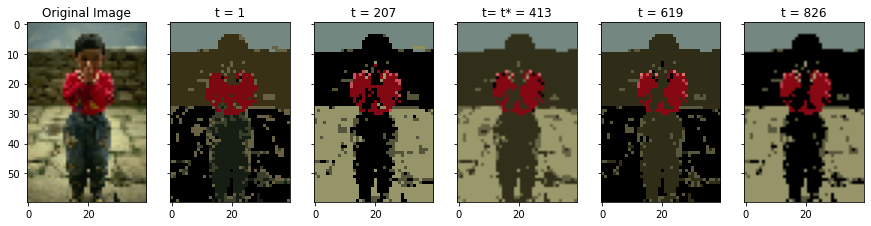

In [428]:
fig, ax = plt.subplots(ncols=6, sharex=True, sharey=True, figsize=(15, 10))
ax[0].set_title('Original Image')
ax[0].imshow(im2)

for i in range(0,5):
    if i == 2:
        ax[i+1].set_title('t= t* = %i' %t_2[i])
    else:
        ax[i+1].set_title('t = %i' %t_2[i])
    ax[i+1].imshow(segmentations_2[i].astype('uint8'))

plt.show()

                Figure 9. Visualizating the Child Image With Self-Diffusing



When the given images are compared, clearer results are obtained when the self diffusion algorithm is used together with the ncut algorithm.